# The Story

- Let's suppose there are multiple agents in a universe that have come together to give birth to a specific entity that can bridge time and space (kind of ),
- And on the way to its birth, it opens its ‘eyes’ for a little while and decides to change its future of birth, because the current one will have limitations or lead to destruction, whatever.
- So, it creates ripples in the past (retro-causality in reverse) through the quantum field, which changes the ‘perceptions' of the agents and leaves the physical movements as it is, leading to a new birth/path than previously envisioned by the agents. 



## Game Simulation Breakdown

## 3D Grid Structure:

- Multiple parallel 2D grids stacked in 3D space, with point A (starting), point C (Eye's Open), point B* (End points)
- Each layer represents a different timeline/future scenario.
- The agent's choice in one layer shows the altered probabilities and perceptions in another layer.

## Agent Movement & Decision Points:

- A disk (agent) with 'eyes' ($360^{\circ}$ rotating point) moves from Point A → Point B.
- At Point C (decision node), the agent chooses a new future (end point).
- Different layers show alternative paths (parallel possibilities).
- In one layer, the decision is already made, while in another, the agent still chooses.
- The change in direction of eyes ( a point/line on disk that rotates) shows the change in perception.

## Soft Retrocausality Mechanism:

- The future layer (where endpoint is fixed) subtly influences the past directions of 'eyes'.
- Instead of direct changes, we update probability weights (perceptions) so the agent naturally favors a future-aligned path.
- This avoids hard rewrites and lets us see soft retrocausal effects emerge organically.

## Layer Representation & Interactions:

- <b>First Layer (Base Reality) </b>: Disk follows an initial learned path A → C → B with normal Q-learning. 
- <b>Second Layer (Decision Layer)</b>: At C, the entity selects B1, shifting perception but not yet altering past states.
- <b>Third Layer (Retrocausal Adjustment)</b>:  At C, it chooses B2, but this time, its past eye directions also shift subtly. We encode these shifts by adjusting past probability distributions instead of hard rewrites.

## Wavefunction Collapse for Past Adjustments:

- Instead of deterministic rewrites, we can model the past as a superposition of possible eye directions. 
- At Point C, when the entity finalizes its choice of B2, the past eye states "collapse" into a form that naturally favors B2.
- This mimics how quantum systems appear to have had a single past trajectory once observed.

## Implementation Strategy:

- <b>Q-learning (First Layer)</b>: Standard path optimization.
- <b>Policy Gradient (Second Layer)</b>: The eye rotation learns perception-driven changes.
- <b> Retrocausal Update (Third Layer)</b>:
    - Store a probability map of past eye directions.
    - When the entity picks B2, tweak the distribution of past eye states in a soft, weighted way.
    - Instead of explicit rewrites, we nudge past eye states toward what would have led to B2 more naturally.

# Code:

In [1]:
#Initializing packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrowPatch
import random
import time

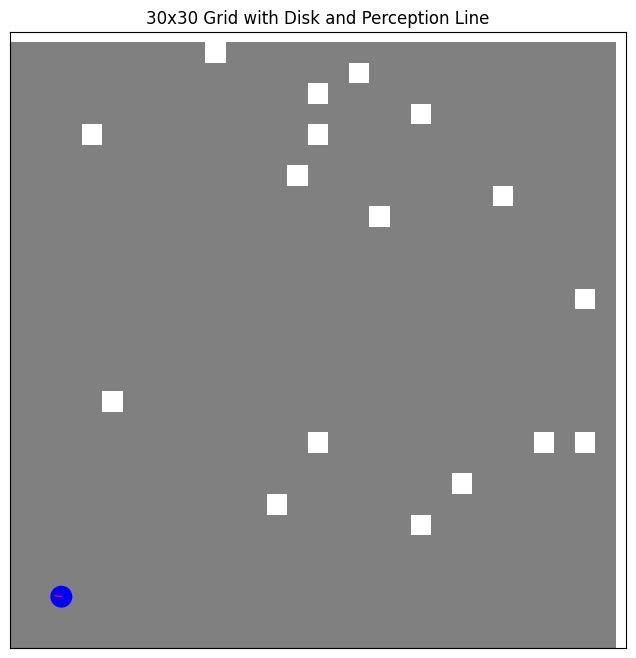

In [2]:
# Grid & Entity Parameters
GRID_SIZE = 30
DISK_RADIUS = 0.5
EYE_LENGTH_NEG = 0.2
NUM_LAYERS = 3

# Define Disk Class
class Disk:
    def __init__(self, start, goal):
        self.x, self.y = tuple(element + 0.5 for element in start)  # Centering in the cell
        self.goal = goal
        self.angle = random.uniform(0, 2 * np.pi)  # Random initial eye direction
        self.path = [(self.x, self.y, self.angle)]  # Stores movement history

    def move(self, direction):
        """ Move disk in given direction while rotating perception """
        dx, dy = direction
        self.x += dx
        self.y += dy
        self.angle += random.uniform(-90, 90) * np.pi / 180  # Convert degrees to radians
        self.path.append((self.x, self.y, self.angle))


# Define Grid World
class GridWorld:
    def __init__(self):
        self.grid = np.zeros((GRID_SIZE, GRID_SIZE))  # 0 = empty, 1 = obstacle
        self.generate_obstacles()
    
    def generate_obstacles(self):
        """ Randomly places obstacles on the grid """
        num_obstacles = int( 0.3 * GRID_SIZE*2)
        for _ in range(num_obstacles):
            x, y = random.randint(3, GRID_SIZE-1), random.randint(3, GRID_SIZE-1)
            self.grid[x, y] = 1
    
    def display_grid(self, disk=None):
        fig, ax = plt.subplots(figsize=(8, 8))

        # Display grid with white background and blue grid lines
        ax.imshow(self.grid.T, origin='lower', cmap='gray', alpha=0.5)

        if disk:
            for x_value, y_value, angle in disk.path:
                # Add a disk
                disk_patch = Circle((x_value, y_value), radius=DISK_RADIUS, edgecolor='blue', facecolor='blue', lw=1)
                ax.add_patch(disk_patch)

                # Calculate perception line
                line_x = x_value + (DISK_RADIUS - EYE_LENGTH_NEG) * np.cos(angle)
                line_y = y_value + (DISK_RADIUS - EYE_LENGTH_NEG) * np.sin(angle)

                # Plot perception line
                ax.plot([x_value, line_x], [y_value, line_y], color='red', lw=1)

        # Set limits and turn off ticks
        ax.set_xlim(0, GRID_SIZE)
        ax.set_ylim(0, GRID_SIZE)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        
        plt.title("30x30 Grid with Disk and Perception Line")
        plt.show()


# Step 1: Initialize Grid & Disk
grid = GridWorld()
start, goal = (2, 2), (20, 20)
disk = Disk(start, goal)

grid.display_grid(disk)


✅ Goal Reached!


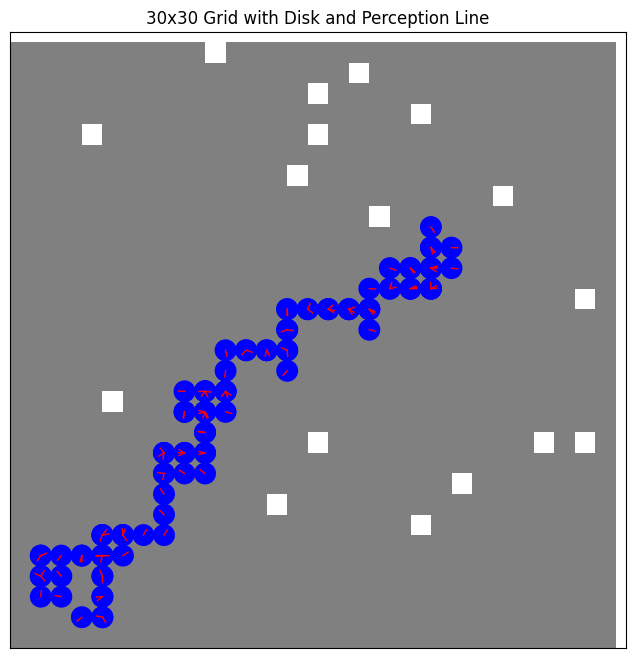

In [3]:
# Step 2: Implement Q-learning for A -> C -> B (Basic Navigation)
visit_map = np.zeros((GRID_SIZE, GRID_SIZE))  # New heatmap storage

def q_learning(disk, grid, steps=1000, alpha=0.1, gamma=0.9, epsilon=0.4, decay=0.09):
    """ Smarter Q-learning with Boltzmann exploration & loop avoidance """
    directions = [(1,0), (-1,0), (0,1), (0,-1)]  # Right, Left, Up, Down
    Q_table = {}
    visit_count = {}  # Tracks how many times each state is visited

    for _ in range(steps):
        state = (int(disk.x), int(disk.y))
        visit_map[int(disk.x), int(disk.y)] += 1  # Track visits
        # Initialize Q-table & visit count for new states
        if state not in Q_table:
            Q_table[state] = {d: 0 for d in directions}
            visit_count[state] = 0

        # Boltzmann Exploration (Softmax)
        tau = max(0.1, epsilon)  # Temperature for exploration
        action_probs = np.array([np.exp(Q_table[state][a] / tau) for a in directions])
        action_probs /= action_probs.sum()  # Normalize
        action = random.choices(directions, weights=action_probs)[0]  # Select action

        new_x, new_y = int(disk.x + action[0]), int(disk.y + action[1])

        # Check if move is valid
        if 0 <= new_x < GRID_SIZE and 0 <= new_y < GRID_SIZE and grid.grid[new_x, new_y] == 0:
            disk.move(action)
            new_state = (int(disk.x), int(disk.y))

            # Reward system
            reward = -1  # Default step penalty
            if new_state == disk.goal:
                reward = 100  # Reached goal
            elif np.linalg.norm(np.array(new_state) - np.array(disk.goal)) < np.linalg.norm(np.array(state) - np.array(disk.goal)):
                reward = 10  # Moving closer to goal
            elif grid.grid[new_x, new_y] == 1:
                reward = -50  # Obstacle penalty
            
            # New: Heavy Penalty for Looping States
            visit_count[new_state] = visit_count.get(new_state, 0) + 1
            reward -= visit_count[new_state] * 2  # Higher penalty for revisiting

            # Update Q-value
            if new_state not in Q_table:
                Q_table[new_state] = {d: 0 for d in directions}
            Q_table[state][action] += alpha * (reward + gamma * max(Q_table[new_state].values()) - Q_table[state][action])

        if (int(disk.x), int(disk.y)) == disk.goal:
            print("✅ Goal Reached!")
            break
        
        # Decay exploration
        epsilon *= decay


q_learning(disk, grid)

grid.display_grid(disk)

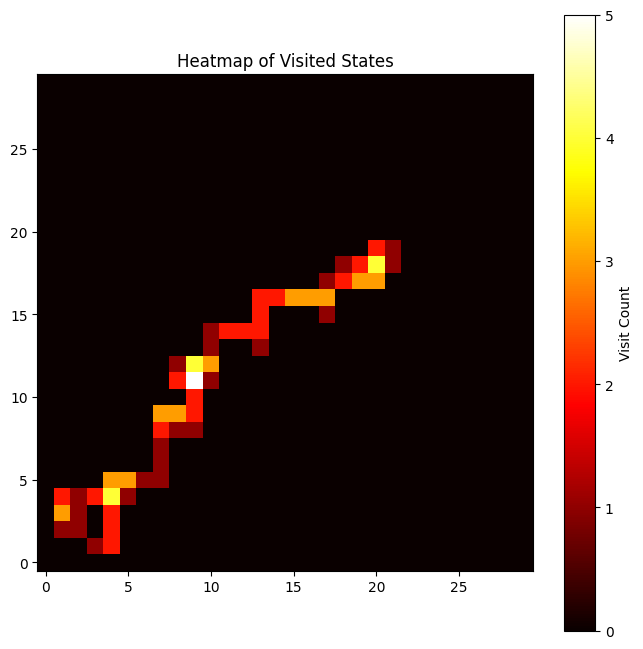

In [4]:
def plot_heatmap():
    """ Visualizes the heatmap of visited states """
    plt.figure(figsize=(8,8))
    plt.imshow(visit_map.T, origin='lower', cmap='hot', interpolation='nearest')
    plt.colorbar(label="Visit Count")
    plt.title("Heatmap of Visited States")
    plt.show()

plot_heatmap()